In [1]:
#The following installs the necessary python libraries to run this code
!pip install -q "openvino-dev>=2023.1.0"
!pip install -q tensorflow
!pip install -q opencv-python requests tqdm

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

print("Installation of packages has been satisfied!")

Installation of packages has been satisfied!


In [2]:
#the following are the necessary imports for this model to run
import collections
import tarfile
import time
from pathlib import Path

import cv2
import numpy as np
from IPython import display
import openvino as ov
from openvino.tools.mo.front import tf as ov_tf_front
from openvino.tools import mo

import notebook_utils as utils

print("All packages have been imported!")

All packages have been imported!


In [3]:
# A directory where the model will be downloaded.
base_model_dir = Path("model")

# The name of the model from Open Model Zoo
model_name = "ssdlite_mobilenet_v2"

archive_name = Path(f"{model_name}_coco_2018_05_09.tar.gz")
model_url = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/public/2022.1/{model_name}/{archive_name}"

# Download the archive
downloaded_model_path = base_model_dir / archive_name
if not downloaded_model_path.exists():
    utils.download_file(model_url, downloaded_model_path.name, downloaded_model_path.parent)
    print("The model has been downloaded to path")

# Unpack the model
tf_model_path = base_model_dir / archive_name.with_suffix("").stem / "frozen_inference_graph.pb"
if not tf_model_path.exists():
    with tarfile.open(downloaded_model_path) as file:
        file.extractall(base_model_dir)


print("the model has been downloaded and unpacked!")

model\ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz:   0%|          | 0.00/48.7M [00:00<?, ?B/s]

The model has been downloaded to path


C:\Users\Pierre\AppData\Local\Temp\ipykernel_10700\2760276346.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  file.extractall(base_model_dir)


the model has been downloaded and unpacked!


In [4]:
#the following will convert the TensorFlow formatted model to OpenVINO IR format:
#the Model Conversion API (mo.convert_model function) will be used 

precision = "FP16"
# The output path for the conversion.
converted_model_path = Path("model") / f"{model_name}_{precision.lower()}.xml"

# Convert it to IR if not previously converted
trans_config_path = Path(ov_tf_front.__file__).parent / "ssd_v2_support.json"
if not converted_model_path.exists():
    ov_model = mo.convert_model(
        tf_model_path,
        compress_to_fp16=(precision == 'FP16'),
        transformations_config=trans_config_path,
        tensorflow_object_detection_api_pipeline_config=tf_model_path.parent / "pipeline.config",
        reverse_input_channels=True
    )
    ov.save_model(ov_model, converted_model_path)
    del ov_model

[ INFO ] MO command line tool is considered as the legacy conversion API as of OpenVINO 2023.2 release.
In 2025.0 MO command line tool and openvino.tools.mo.convert_model() will be removed. Please use OpenVINO Model Converter (OVC) or openvino.convert_model(). OVC represents a lightweight alternative of MO and provides simplified model conversion API. 
Find more information about transition from MO to OVC at https://docs.openvino.ai/2023.2/openvino_docs_OV_Converter_UG_prepare_model_convert_model_MO_OVC_transition.html


[ WARNING ]  The Preprocessor block has been removed. Only nodes performing mean value subtraction and scaling (if applicable) are kept.


In [5]:
#this code cell will load the model
#you can choose wether to run it on CPU or GPU when changing the value of
#'value', 'value' could be ('AUTO','GPU','CPU','NPU'), AUTO wil choose the best option

import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='GPU',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'GPU', 'NPU', 'AUTO'), value='GPU')

In [6]:
# Read the network and corresponding weights from a file.
#this basically reads the pretrained model's data so we run it
model = core.read_model(model=converted_model_path)
# Compile the model for CPU (you can choose manually CPU, GPU etc.)
# or let the engine choose the best available device (AUTO).
compiled_model = core.compile_model(model=model, device_name=device.value)

# Get the input and output nodes.
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

# Get the input size.
height, width = list(input_layer.shape)[1:3]

In [7]:
#Input and output layers have the names of the input node and output node
#respectively. In the case of SSDLite MobileNetV2, there is 1 input and 1 output.
input_layer.any_name, output_layer.any_name


('image_tensor:0', 'detection_boxes:0')

In [8]:
#We need to list all available classes and create colors for them
# this will alow us to then choose which objects we want to detect and
# which we want to ignore
# we can use the following to see what type of object detection classes
# are present within the dataset:
# https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
#here are some example classes:
classes = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "street sign", "stop sign",
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant",
    "bear", "zebra", "giraffe", "hat", "backpack", "umbrella", "shoe", "eye glasses",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
    "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "plate", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "mirror", "dining table", "window", "desk", "toilet",
    "door", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "blender", "book", "clock", "vase", "scissors",
    "teddy bear", "hair drier", "toothbrush", "hair brush"
]

#this defines the Colors for the classes above (Rainbow Color Map)
# Colors for the classes above (Rainbow Color Map).
colors = cv2.applyColorMap(
    src=np.arange(0, 255, 255 / len(classes), dtype=np.float32).astype(np.uint8),
    colormap=cv2.COLORMAP_RAINBOW,
).squeeze()

# this processes the results
#try changing the threshold and see what happens (should start ignoring/recognising objects based on probability)

def process_results(frame, results, thresh=0.6):
    # The size of the original frame.
    h, w = frame.shape[:2]
    # The 'results' variable is a [1, 1, 100, 7] tensor.
    results = results.squeeze()
    boxes = []
    labels = []
    scores = []
    for _, label, score, xmin, ymin, xmax, ymax in results:
        # Create a box with pixels coordinates from the box with normalized coordinates [0,1].
        boxes.append(
            tuple(map(int, (xmin * w, ymin * h, (xmax - xmin) * w, (ymax - ymin) * h)))
        )
        labels.append(int(label))
        scores.append(float(score))
#the following implements the No Maximum Suppression threshold
#which allows a threshold depicting wether to show overlapping objects or not
# it is a sensitivity threshold
# change the value of the threshold to see how it changes object detection in overlapping
# objects


    # Apply non-maximum suppression to get rid of many overlapping entities.
    # See https://paperswithcode.com/method/non-maximum-suppression
    # This algorithm returns indices of objects to keep.
    indices = cv2.dnn.NMSBoxes(
        bboxes=boxes, scores=scores, score_threshold=thresh, nms_threshold=0.6
    )

    # If there are no boxes.
    if len(indices) == 0:
        return []

    # Filter detected objects.
    return [(labels[idx], scores[idx], boxes[idx]) for idx in indices.flatten()]

# this method draws the boxes around the object:
def draw_boxes(frame, boxes):
    for label, score, box in boxes:
        # Choose color for the label.
        color = tuple(map(int, colors[label]))
        # Draw a box.
        x2 = box[0] + box[2]
        y2 = box[1] + box[3]
        cv2.rectangle(img=frame, pt1=box[:2], pt2=(x2, y2), color=color, thickness=3)

        # Draw a label name inside the box.
        cv2.putText(
            img=frame,
            text=f"{classes[label]} {score:.2f}",
            org=(box[0] + 10, box[1] + 30),
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=frame.shape[1] / 1000,
            color=color,
            thickness=1,
            lineType=cv2.LINE_AA,
        )

    return frame

In [9]:
# the following is the Main Processing Function
# the object detection can be run on either webcam or a specifc video input
# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0):
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )

            # Resize the image and change dims to fit neural network input.
            input_img = cv2.resize(
                src=frame, dsize=(width, height), interpolation=cv2.INTER_AREA
            )
            # Create a batch of images (size = 1).
            input_img = input_img[np.newaxis, ...]

            # Measure processing time.

            start_time = time.time()
            # Get the results.
            results = compiled_model([input_img])[output_layer]
            stop_time = time.time()
            # Get poses from network results.
            boxes = process_results(frame=frame, results=results)

            # Draw boxes on a frame.
            frame = draw_boxes(frame=frame, boxes=boxes)

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

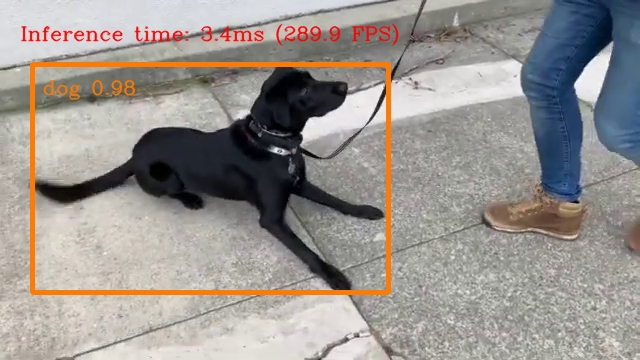

Source ended


In [10]:
# in order to use a webcam, the default webcam address is source=0
# the source depends on the number of webcams setup
# setting flip=True is necessary when using front webcam
# when experiencing flickering do: use_popup=True and that should fix it

# NOTE: the webcam will only work if you run on computer hardware and not on a 
# server such as (Binder). 

#the following shows how to run the model on a sepcific video input

USE_WEBCAM = False

#this is the video directory we are using
video_file = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4"
#here are some other video sources to test out:
# a good practice is to change the threshold's above to fine tune the model for better object detection
#coco walking (current video above): https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4
#people: https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/people.mp4
#intel video: https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Sheldon%20Cooper%20Jim%20Parsons%20at%20Intels%20Lab.mp4
cam_id = 0

source = cam_id if USE_WEBCAM else video_file

run_object_detection(source=source, flip=isinstance(source, int), use_popup=False)